# Merged Station Analizer
***
#####     **module**     :: test_merged_CDM.py        
#####     **author**     :: Federico Ambrogi , federico.ambrogi@univie.ac.at 
#####     **desciption** :: Analyzes the merged file produced by the utility merging_all_last.py   
***

In [1]:
%matplotlib inline
%pylab inline

import os,sys
import netCDF4 as nc
import xarray as xr
import pandas as pd
import time
import numpy as np
from tqdm import tqdm
from collections import Counter
import datetime

import matplotlib
from matplotlib import ticker

#matplotlib.use('Agg')


import matplotlib.pylab as plt


""" Setting pandas printing output """
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Initialization of the Input Files
***

In [2]:
""" Input file(s) """

data = {'path': '/raid8/srvx1/federico/GitHub/CEUAS_master_MAY/CEUAS/CEUAS/public/merge/FINAL_remove_time_shifts_94996_/0-20000-0-10393_CEUAS_merged_v0.nc',
        'name': 'Lindenberg (Germany)' }


#data = {'path': '/raid8/srvx1/federico/GitHub/CEUAS_master_MAY/CEUAS/CEUAS/public/merge/FINAL_remove_time_shifts_94996_/0-20000-0-94996_CEUAS_merged_v0.nc',
#        'name': 'Norfolk Island (Removed Time Shifts = 2hrs )' }

""" Reading info from the file path and name """
merged_file = data['path']
station_name = data['name']
station = merged_file.split("0-20000-0-")[1].replace("_CEUAS_merged_v0.nc",'')



""" Output Directory """
out_dir = os.getcwd() + '/Plots/Test_Merged'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
    
    
""" Reading input merged file with xarray """

data_false = xr.open_dataset(merged_file , engine = 'h5netcdf' , decode_times = False )
recordtimestamp_false = data_false["recordtimestamp"].values

data = xr.open_dataset(merged_file , engine = 'h5netcdf' , decode_times = True )

recordtimestamp = data["recordtimestamp"]
recordindex     = data["recordindex"]


dictionary_dates = dict(zip( recordtimestamp_false , recordtimestamp.values ) )


""" Loading the observations_table """
print(" Loading the observations table ")
ot_all   = xr.open_dataset( merged_file , engine = 'h5netcdf' , group = "observations_table", decode_times = True ).to_dataframe()
print("+++ Done loading pandas observations_table")    


""" Loading the source_configuration """
print(" Loading the source_configuration table")
sc   = xr.open_dataset( merged_file , engine = 'h5netcdf' , group = "source_configuration", decode_times = True ).to_dataframe()
print("+++ Done loading pandas source_configuration")


""" Loading the header_table """
print(" Loading the header_table ")
ht   = xr.open_dataset( merged_file , engine = 'h5netcdf' , group = "header_table", decode_times = True ).to_dataframe()
print("+++ Done loading pandas header_table")


""" Selecting only interesting columns """
columns = ["date_time" , "z_coordinate" , "z_coordinate_type", "observed_variable","observation_value" , "source_id", "observation_id" , "report_id"]
ot = ot_all[columns]

file_used = np.unique( sc.index) # to access the data you must get the indces since it is an empty dataframe 
#print(file_used)

    

 Loading the observations table 
+++ Done loading pandas observations_table
 Loading the source_configuration table
+++ Done loading pandas source_configuration
 Loading the header_table 
+++ Done loading pandas header_table


In [3]:
""" Class holding general properties of the plots """
class Common():
    def __init__(self):
        
        """ For plotting style """
        style_dic = {85 : { 'l': 'Air Temperature [K]'         , 'c': 'blue'      } , 
                     117: { 'l': 'Geopotential [m]'            , 'c': 'green'     } ,
                     104: { 'l': 'Wind u-component [m/s]'      , 'c': 'gold'      } ,
                     105: { 'l': 'Wind v-component [m/s]'      , 'c': 'limegreen' } ,
                     107: { 'l': 'Wind speed [m/s]'            , 'c': 'black'     } ,
                     106: { 'l': 'Wind from direction'         , 'c': 'cyan'      } ,    
                    }
    
        datasets_dic = {'era5_1'     : { 'l': 'ERA5 1'    , 'c': 'blue'      } ,
                        'era5_2'     : { 'l': 'ERA5 2'    , 'c': 'limegreen' } ,
                        'ncar'       : { 'l': 'NCAR'      , 'c': 'purple'    } ,
                        'igra2'      : { 'l': 'IGRA2'     , 'c': 'cyan'      } ,
                        'era5_1759'  : { 'l': 'ERA5 1759' , 'c': 'gray'      } ,
                        'era5_1761'  : { 'l': 'ERA5 1761' , 'c': 'pink'      } ,
                        'era5_3188'  : { 'l': 'ERA5 3188' , 'c': 'yellow'    } ,
                        'bufr'       : { 'l': 'BUFR'      , 'c': 'green'     } ,
                    }
        
        self.style_dic    = style_dic
        self.datasets_dic = datasets_dic 
        self.std_plevs    = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000]
        self.fontsize     = 15
        self.datasets     = ["era5_1" , "era5_2" , "era5_1759" , "era5_1761" , "era5_3188" , "bufr" , "ncar" , "igra2" ]
Common = Common()

""" Standard pressure levels in hPa """
std_plevs = Common.std_plevs

In [4]:
#Checks that the recordtimestamp and recordindex are monotonously increasing

#def check_dates_consistency(indices):
#    wrong = False
#    for dt,i,t in zip(indices, range(len(indices)),tqdm(range(len(indices)) ) ):
#        if i == 0:
#            continue
#        else:
#            if dt < indices[i-1]:
#                print(" +++ ERROR: found a value which is lower than the previous ")
#                wrong =  True
#    return wrong


#check_indices_record = check_dates_consistency(recordindex)
#if check_indices_record:
#    print("+++ ERROR! Found a mistake in the recordindex")


In [24]:
def plot_timeseries(data= '', variables= '' , p_levels= '' , station= '' , date_range= ['',''] , print_df = False , text = ''):
    """ Function to plot time series """

    datasets_dic = Common.datasets_dic
    style_dic    = Common.style_dic
    fs           = Common.fontsize 

    date_min, date_max = date_range[0], date_range[1]
    
    for v in variables:

        data_v = data.loc[ (data['observed_variable'] == v) ]
        
        
        for p in p_levels:
            
            data_p = data_v.loc[ (data_v["z_coordinate"] == p ) & ( data_v["z_coordinate_type"] == 1)  ] # filtering on various pressure levels

            #plt.figure(figsize=(20,10)) 
            fig, ax = plt.subplots(figsize=(16,9))
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.tick_params(axis='both', which='minor', labelsize=8)
        
            plt.grid(ls =":" , color = "lightgray")
            
            if  date_min and date_max:
                data_p = data_p.loc[ (data_p["date_time"] >= date_min ) & (data_p["date_time"] < date_max )  ] # option filtering on date range

                plt.xlim(date_min, date_max)
            
            source_datasets = np.unique(data_p["source_id"][:])
            print("All sources::: " , source_datasets )
    
            for s in [ b'era5_1759', b'igra2', b'ncar', b'era5_1' , b'era5_2']:
            #for s in source_datasets:
                d = data_p.loc[ (data_p['source_id'] == s) ]
                x = d["date_time"].values
                y = d["observation_value"].values
                S = s.decode("utf-8")
                #S = s
                #print("Length for " , str(S) , " is: ", len(x) ) 
            
                num    = '[' + str(len(x)) + ']'
                legend =  datasets_dic[S]['l'] + ' ' + num 
                color  = datasets_dic[S]['c']
            
                #plt.plot(x, y, label = legend , color = color )
                plt.scatter(x, y, label = legend , color = color )
                
                """ Print here the dataframe """
                if print_df:
                    dates = [datetime.datetime(1959,12,14) , datetime.datetime(1959,12,15)]
                    df = d.loc [ (d["date_time"] >= dates[0]) & (d["date_time"] < dates[1])     ] 
                    pd.set_option('expand_frame_repr', False)

                    if not df.empty:
                        print( '  ' + S + '--------------------------------------------------------------------------------' , '\n', df)
        
            #plt.xlabel("Date Time", fontsize = fs)
            pressure = str(int(p/100) )
            plt.ylabel( style_dic[v]['l'] , fontsize = fs + 2 )
            
            #levels    = [100000, 50000, 1000]    

            #plt.text(0.73, 0.93, 'Plevel=' + pressure + ' [hPa]' , transform=ax.transAxes, color = 'red', fontsize = fs+5)
            
            plt.legend(loc = 'best', fontsize = fs)    

            
            plt.title("Station " + station + ' - Plevel=' + pressure + ' [hPa]' , fontsize = fs + 4, y = 1.03 )
            
            plt.savefig(out_dir + '/' + station + "_time_series_" + "_pressure_" + pressure + "_var_" + str(v) + text + ".pdf",
                         bbox_inches = 'tight' , dpi = 250 )
            plt.show()
            plt.close()
            print("*** Plot created for variable ", v , "  at pressure level " , str(p) )
        
        


## Time series for selected variables
***

All sources:::  [b'era5_1' b'era5_1759' b'era5_2' b'igra2' b'ncar']


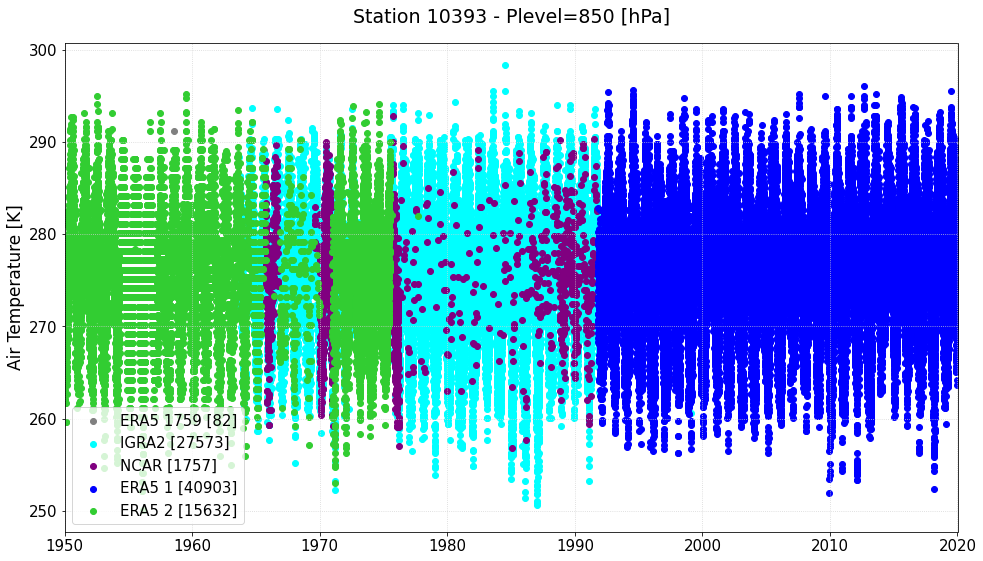

*** Plot created for variable  85   at pressure level  85000
All sources:::  [b'era5_1' b'era5_1759' b'era5_2' b'igra2' b'ncar']


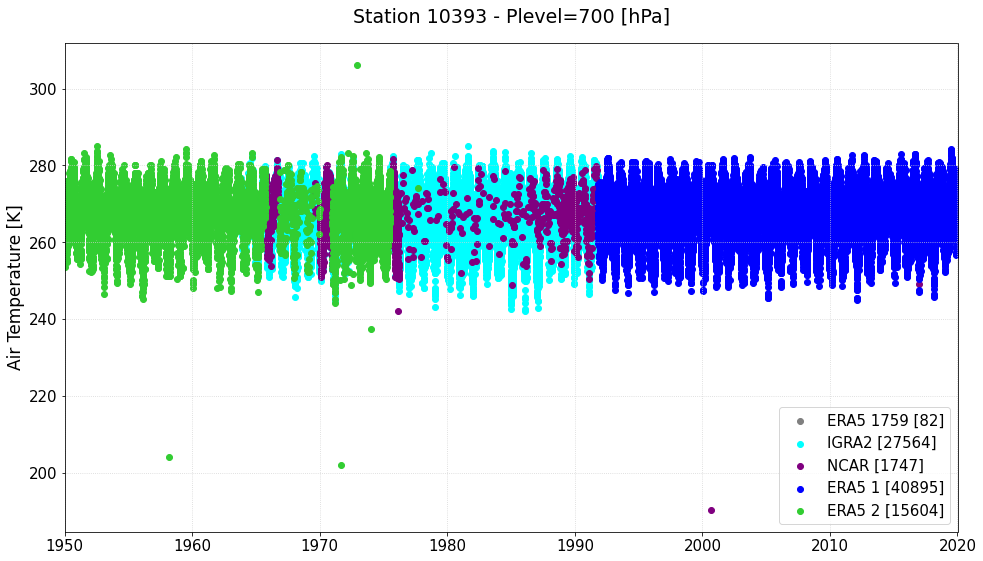

*** Plot created for variable  85   at pressure level  70000
All sources:::  [b'era5_1' b'era5_1759' b'era5_2' b'igra2' b'ncar']


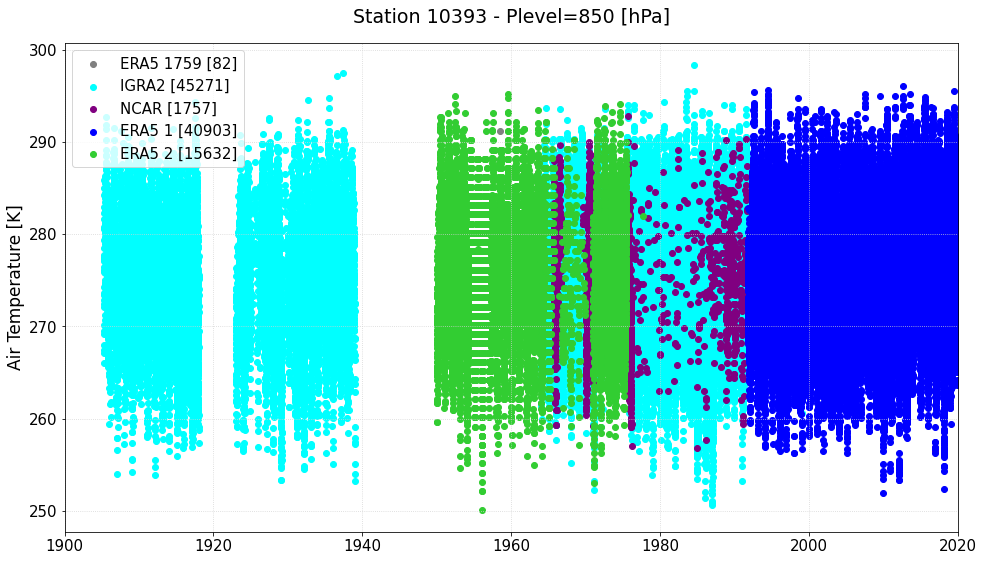

*** Plot created for variable  85   at pressure level  85000
All sources:::  [b'era5_1' b'era5_1759' b'era5_2' b'igra2' b'ncar']


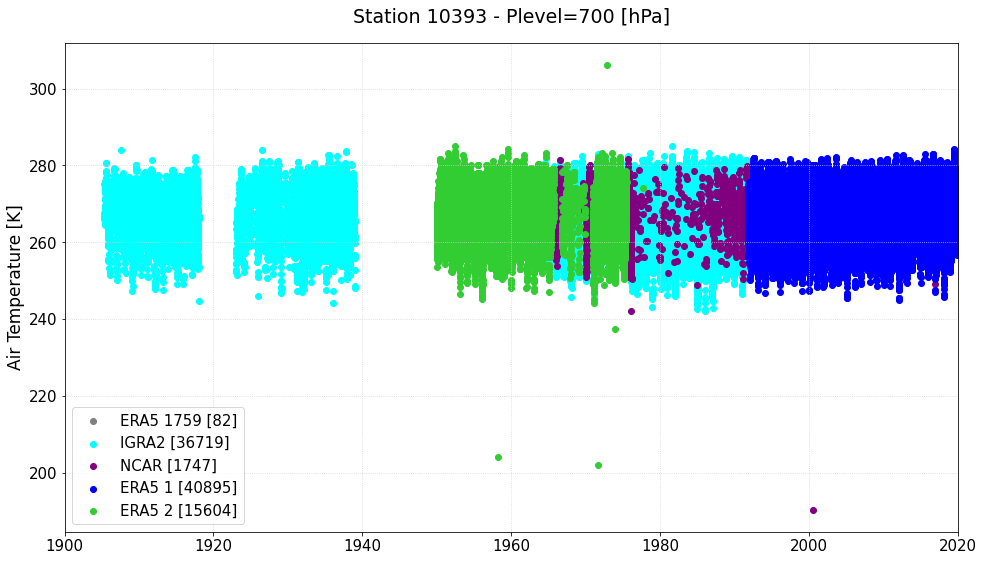

*** Plot created for variable  85   at pressure level  70000


In [25]:
""" Select variable and a date_time range to plot """

#variables = [85,104,105,106,107,117]
#levels    = [100000, 50000, 1000]    

variables = [85,104,105,106,107,117]
levels    = [100000, 90000, 50000, 1000]    


variables = [85]
levels    = [100000,1000]  

variables = [85]
levels    = [85000, 70000]  


# ----------------------------------------------------------------------------------------------------------------------------

date_min = '1950-01-01 00:00:00.1'
date_max = '2020-01-01 00:00:00.1'
min_dt = datetime.datetime.strptime(date_min, '%Y-%m-%d %H:%M:%S.%f')
max_dt = datetime.datetime.strptime(date_max, '%Y-%m-%d %H:%M:%S.%f')
do = plot_timeseries(data = ot, variables = variables , p_levels = levels , station = station,  date_range = [min_dt,max_dt] , text = '_all' ) 

# ----------------------------------------------------------------------------------------------------------------------------
date_min = '1900-01-01 00:00:00.1'
date_max = '2020-01-01 00:00:00.1'
min_dt = datetime.datetime.strptime(date_min, '%Y-%m-%d %H:%M:%S.%f')
max_dt = datetime.datetime.strptime(date_max, '%Y-%m-%d %H:%M:%S.%f')
do = plot_timeseries(data = ot, variables = variables , p_levels = levels , station = station,  date_range = [min_dt,max_dt] , text = '1900_2020' ) 

# ----------------------------------------------------------------------------------------------------------------------------
date_min = '1959-12-11 00:00:00.1'
date_max = '1959-12-15 00:00:00.1'
min_dt = datetime.datetime.strptime(date_min, '%Y-%m-%d %H:%M:%S.%f')
max_dt = datetime.datetime.strptime(date_max, '%Y-%m-%d %H:%M:%S.%f')
#do = plot_timeseries(data = ot, variables = variables , p_levels = levels , station = station,  date_range = [min_dt,max_dt] , print_df = True) 

variables = [85,104,105,106,107,117]

In [ ]:
def plot_dataset_hist(data= "" ,  variables= '' , p_levels= '' , station= '' , date_range= ['',''] , text='' , text_save = ''):
    """ Function to plot the distributions of datasets used in the merged file.
        Works with header_table or observations_table df (header is faster) """
    
    os.system('mkdir output')
    
    all_sources = set(data["source_id"])

    #S = s.decode("utf-8")
    
    if  date_min and date_max:
        D = data.loc[ (data["date_time"] >= date_min ) & 
                    (data["date_time"] < date_max )  ] # option filtering on date range
    
    
    """ Retrieving the style dictionaries """
    datasets_dic = Common.datasets_dic
    style_dic    = Common.style_dic
    fs = Common.fontsize - 2
    
    def count_data(data):
        """ Counts data for the plot, make lables etc. """
        occ = dict(Counter(data["source_id"]) ) # Counter returns a dic with keys= all the items in the list, values=number of occurences per each item 
        for s in all_sources: #  putting back the sources with zero entries for nicer plots 
            if s not in list(occ.keys()):
                occ[s] = 0
       
        counts , labels, color = [], [] , []
        
        for source in Common.datasets:  # the double loops allows to plot the datasets always in the order defined in the list Common.all_sources

            for k,v in occ.items():

                l = k.decode("utf-8")
                if source == l:
                    labels.append(datasets_dic[l]["l"])
                    counts.append(v)
                    color .append( datasets_dic[l]["c"] )
                else:
                    continue 

        x = np.arange(len(occ)) # np.arange(3) = array([0, 1, 2])

        return counts, labels, color, x

   
    def plot_bar(data= '', ax = '', rotation = False , text = '' , station = ''):
        """ Creates a simple bar plots """
        counts, labels, color, x = count_data(data)
        
        if not ax:
            fig, ax = plt.subplots(figsize=(10,7))
            
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        ax.yaxis.set_major_formatter(formatter) 
    
        ax.grid(ls =":" , color = "lightgray")
        ax.bar(x, counts, color = color )
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize = fs )
        if rotation:
            ax.set_xticklabels(labels, rotation = 45, fontsize = fs )

    
    """ Global counts (all pressure levels) """
    #print("Plotting ::: Global counts (all pressure levels)")
    a = plot_bar(data=data , text= text, station = station)
    plt.ylabel("Data Counts (all records)", fontsize = fs )
    plt.title('Record counts per data source for Station ' + str(station) + ' ' + text , y=1.02 , fontsize = fs )

    plt.savefig( out_dir + '/' + station + "_datasets_distribution_global.pdf",
                bbox_inches = 'tight' , dpi = 250 )    
    plt.show()
    plt.close()    
        
              
    """ Global standard level counts (only available for observations_table ) """
    #std_plevs = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000]    
    std_plevs = Common.std_plevs
    
    standard_lev_data  = data.loc[ (data['z_coordinate'] == 10   ) |  
                                   (data['z_coordinate'] == 20   ) |
                                   (data['z_coordinate'] == 30   ) |
                                   (data['z_coordinate'] == 50   ) |
                                   (data['z_coordinate'] == 70   ) |
                                   (data['z_coordinate'] == 100  ) |
                                   (data['z_coordinate'] == 150  ) |
                                   (data['z_coordinate'] == 200  ) |
                                   (data['z_coordinate'] == 250  ) |
                                   (data['z_coordinate'] == 300  ) |
                                   (data['z_coordinate'] == 400  ) |
                                   (data['z_coordinate'] == 500  ) |
                                   (data['z_coordinate'] == 700  ) |
                                   (data['z_coordinate'] == 850  ) |
                                   (data['z_coordinate'] == 925  ) |
                                   (data['z_coordinate'] == 1000 )   ] 
    
    print("Printing ::: Global standard level counts (only available for observations_table ) ")
    a = plot_bar(data= standard_lev_data , station = station, text = text )
    plt.title('Data counts per data source for Station ' + str(station) + ' ' + text , y=1.02 , fontsize = fs )

    plt.ylabel("Counts (standard pressure levels)", fontsize = fs )
    plt.savefig(out_dir + '/'  + station + "_data_datasets_distribution_standard" + text_save + ".pdf", bbox_inches = 'tight' , dpi = 250 )      
    plt.show()

    plt.close()
    
    
    """ Per-variable dataset distributions (all pressure levels) """
    print("Plotting ::: Per-variable dataset distributions (all pressure levels)")
    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(18,10) )
    fig.suptitle('Data counts per variable and data source for Station ' + str(station) + ' ' + text , y=1.04 , fontsize = fs+3)

    for ax,v in zip(axs.flat, variables):
        ax.set_ylabel("Counts (all records) - " + style_dic[v]['l'] , fontsize = fs )
        data_v = data.loc[ (data['observed_variable'] == v) ]
        plot_bar(data= data_v , ax = ax , rotation = True , station = station, text = text )

    plt.savefig(out_dir + '/'  + station + "_data_datasets_distribution_perVariable" + text_save + ".pdf", bbox_inches = 'tight' , dpi = 250 )   
    plt.show()

    plt.close()

    
    return 0

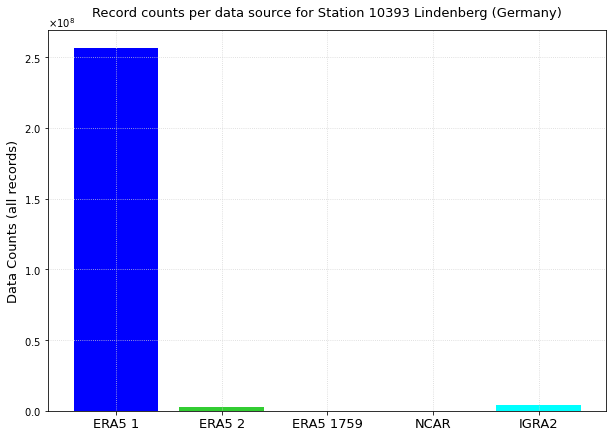

Printing ::: Global standard level counts (only available for observations_table ) 


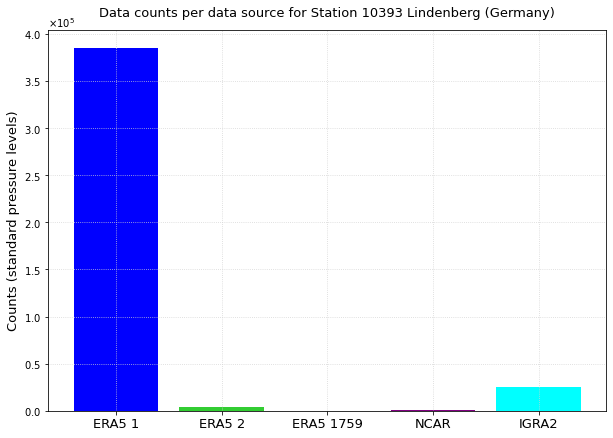

Plotting ::: Per-variable dataset distributions (all pressure levels)


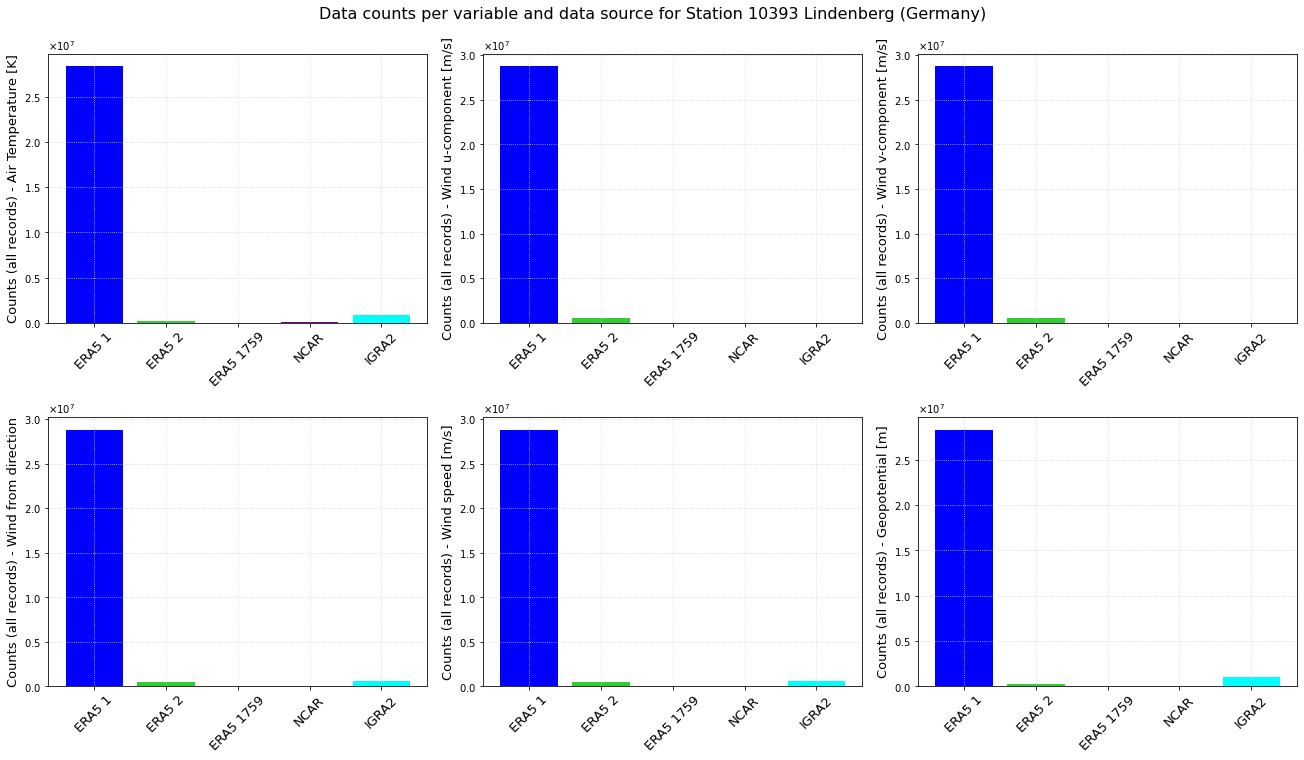

In [15]:
do = plot_dataset_hist(data= ot ,  variables= variables , station= station , date_range= ['',''] , text = station_name , text_save = '' )


In [11]:
def analyze_headers(data= '', station = '', date_min='', date_max='', text = '' , text_save='' , recordtimestamp_false = '' ):
        
    """ Extracts some information from the header table """
    timestamps = data["report_timestamp"]
    #duplicates = data["duplicate"]
    sources = data["source_id"]
        
    datasets_dic = Common.datasets_dic
    style_dic    = Common.style_dic
    fs = Common.fontsize
    
    def get_datasets_datetime(ts, report):
        results = {}
        for datetime, dataset in zip(timestamps, sources):
            #print(datetime, ' ' , dataset )
            datetime = np.datetime64(datetime)
            if dataset not in results.keys():
                results[dataset] = []
            try:
                results[dataset].append(dictionary_dates[datetime] )
            except:
                if type(datetime) != np.datetime64:
    
                    results[dataset].append(dictionary_dates[datetime] )
                else:
                    results[dataset].append(datetime)

        return results
    
    results = get_datasets_datetime(timestamps, sources)

    def plot_timeshifts_distribution(timestamps):
        
        diff = []
        for dt,dtp in zip(timestamps, timestamps[1:]):
            try:
                d = (dtp - dt) / 3600.
                if d > 6:
                    continue
                diff.append(d)
            except:
                pass
        
    
        fig, ax = plt.subplots(figsize=(12,10) ) #    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(15,10) )

        nbins = 24
        plt.hist(diff, nbins, histtype='bar', color = 'magenta')
        plt.xlim(0, 6)
        ax.grid(ls =":" , color = "lightgray")

        plt.xticks( fontsize = fs  )
        plt.ylabel("Record Counts", fontsize = fs )
        plt.xlabel("Time interval [bin = 1/4 hour]", fontsize = fs )


        plt.savefig(out_dir + '/'  + station + "_timeshifts_distribution_" + text_save + ".png", bbox_inches = 'tight' , dpi = 250 )     

        plt.show()
        plt.close()
        
        
    def plot_dataset_range(results, date_min='', date_max='' , text= '', station='' , text_save='' ):
        """ Make a plot for the range of date time availabe for each dataset """
        num_sources = len(results.keys() )
    
        if date_min:
            fig, ax = plt.subplots(figsize=(20,6) ) #    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(15,10) )
        else:
            fig, ax = plt.subplots(figsize=(12,10) ) 
            
        fig.suptitle("Time Interval per Data Source for Station " + station + ' ' + text, y = 0.94, fontsize = fs )

        ticks, labels = [], [] 
        for r,i in zip(results.keys() , range(num_sources)):
            rs = r.decode('utf-8')
            index = i+1
            ticks.append(index)
            label = Common.datasets_dic[rs]['l']
            labels.append(label)
            y = np.empty( len(results[r]) ) 
            y.fill(index)
            plt.scatter(results[r] , y, color = datasets_dic[rs]['c'] , label = label )

        ax.grid(ls =":" , color = "lightgray")

        ax.set_yticks(ticks)
        ax.set_yticklabels(labels, fontsize = fs ,)
        plt.xticks( rotation = 45, fontsize = fs  )
        
        text = ''
        if date_min and date_max:
            plt.xlim(date_min, date_max)
            text = '_zoom_'
            
        
        plt.savefig(out_dir + '/'  + station + "_dataset_series_" + text_save + ".png", bbox_inches = 'tight' , dpi = 250 )     
        
        plt.show()
        plt.close()
        
        
        
    def plot_bar( counts = '', labels = '', rotation = False , text = '' , station = '' , colors = ''):
        """ Creates a simple bar plots """

        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        fig, ax = plt.subplots(figsize=(12,10) )
        ax.yaxis.set_major_formatter(formatter) 
        ax.grid(ls =":" , color = "lightgray")
        X = np.arange(len(counts))
        ax.bar(X, counts, color = colors )
        ax.set_xticks(X)
        ax.set_xticklabels(labels, fontsize = fs )
        if rotation:
            ax.set_xticklabels(labels, rotation = 45, fontsize = fs )

        plt.ylabel("Record Counts", fontsize = fs )
        plt.title('Record counts per data source for Station ' + str(station) + ' ' + text , y=1.02 , fontsize = fs )

        plt.savefig(out_dir + '/'  + station + "_recordcounts_datasets_distribution_global.pdf",
                bbox_inches = 'tight' , dpi = 250 )    
        plt.show()
        plt.close()  
    

    def plot_dataset_distribution(results, date_min='', date_max='', station='', text='' , text_save = 'zoom' ):
        """ Make a histogram for the distribution of date time availabe for each dataset """
        num_sources = len(results.keys() )
    

            
        """ Creating the list for the stacked histogram """
        ticks, labels, X, colors, counts = [], [], [], [], [] 
        Min, Max = [], [] 
        for r, dt in results.items() :
            rs = r.decode('utf-8')
            label = datasets_dic[rs]['l'] + "[" + str(len(dt)) + "]"
            counts.append(len(dt))
            
            labels.append(label)
            colors.append(datasets_dic[rs]['c'] )
            X.append(dt)
            Min.append(min(dt))
            Max.append(max(dt))
            
     
        a = plot_bar( counts = counts, labels = labels, rotation = False , text = '' , station = station , colors = colors)     

        
        if date_min:
            fig, ax = plt.subplots(figsize=(20,6) ) #    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(15,10) )
        else:
            fig, ax = plt.subplots(figsize=(15,10) ) 
            
        """ Extracting hte min and Max years in the range. Needs panda to deal with numpy datetime64 objects"""
        mm = np.array ( [min(Min)] , dtype = np.datetime64 )
        y_min = str(pd.to_datetime(mm).year[0])
        MM = np.array ( [max(Max)] , dtype = np.datetime64 )
        y_max = str(pd.to_datetime(MM).year[0])
        
        #print("min, Max" , y_min[0], y_max[0] )
        
        nbins = int(y_max) - int(y_min)
        plt.hist(X, nbins, histtype='bar', stacked=True, label=labels, color = colors )
    
        ax.grid(ls =":" , color = "lightgray")


        plt.xticks(rotation = 45 , fontsize = fs  )
        plt.yticks(fontsize = fs  )

        
        if date_min and date_max:
            plt.xlim(date_min, date_max)
    
        plt.ylim(0,4600)
        plt.ylabel("Record counts " , fontsize = fs)
        plt.legend(fontsize = fs  , loc = 'best' )
        plt.title("Records Distribution for station " + station + ' ' + text , y = 1.03, fontsize = fs  )
        plt.savefig(out_dir + '/'  + station + "_record_distribution_" + text_save + ".png", bbox_inches = 'tight' , dpi = 250 )     
        
        plt.show()
        plt.close()
        
    p = plot_dataset_range(results , station=station , text = text)
    p = plot_timeshifts_distribution(recordtimestamp_false )
    p = plot_dataset_range(results, date_min= date_min, date_max= date_max , station=station , text = text , text_save = 'zoom' )
    p = plot_dataset_distribution(results, date_min='', date_max='',  station=station , text = text )

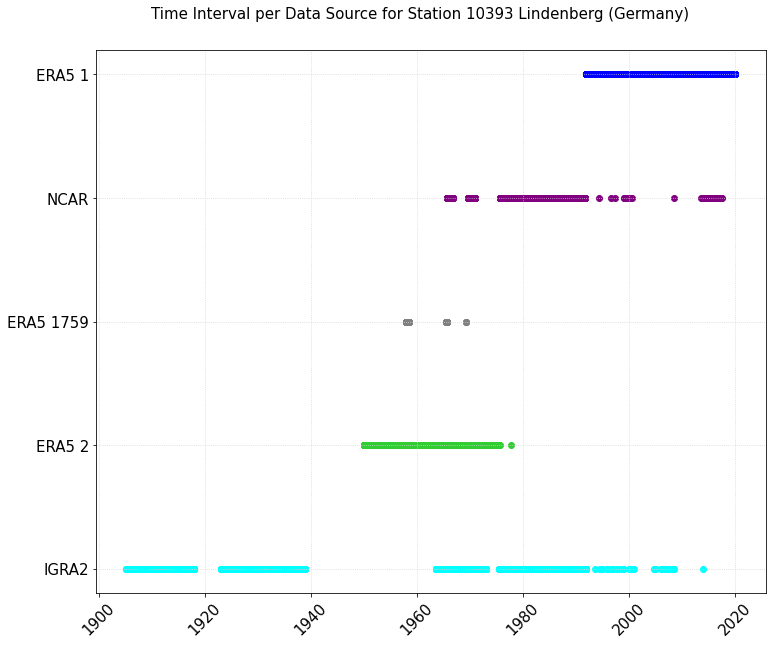

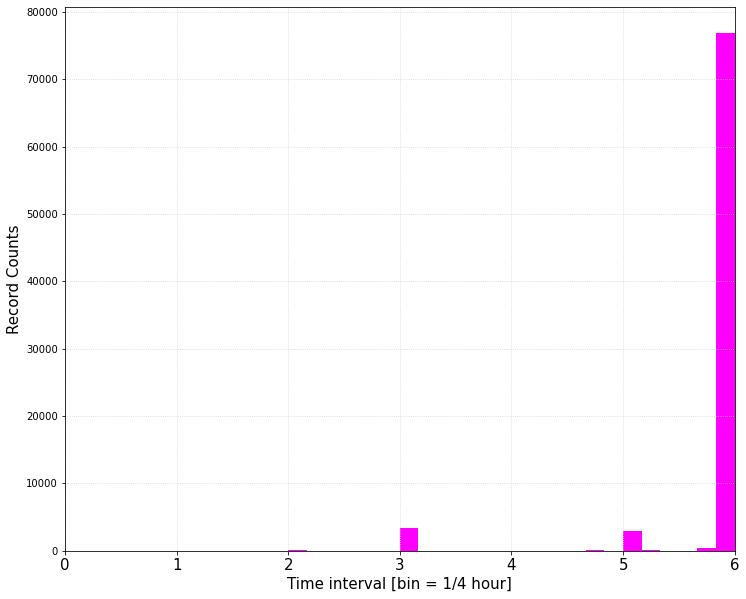

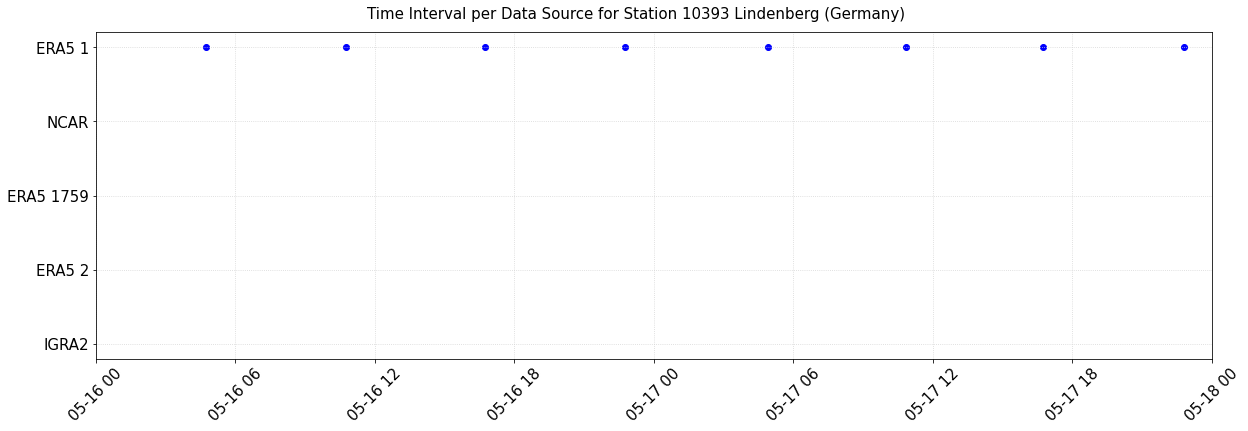

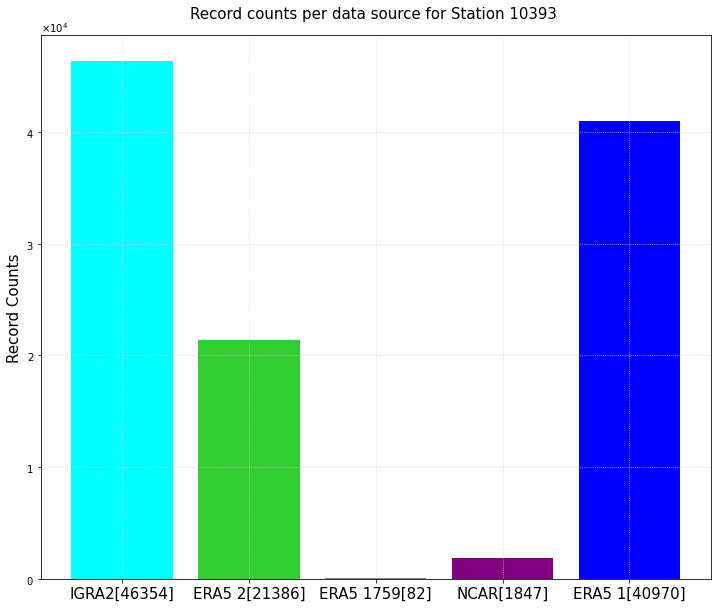

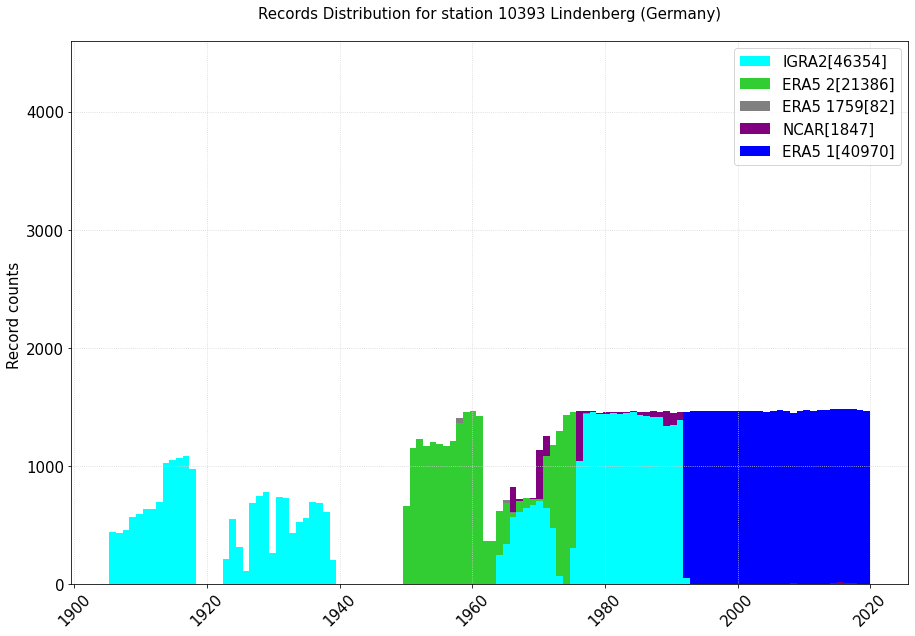

In [12]:
dm , DM = datetime.datetime(2015,5,16,0,0) , datetime.datetime(2015,5,18,0,0)
do = analyze_headers(data= ht, station = station, date_min = dm, date_max = DM, text= station_name , text_save = '' , recordtimestamp_false = recordtimestamp_false )